# Power analysis using `SSPA`

Max Qiu, PhD <br>
Bioinformatician/Computational Biologist <br>
[Bioinformatics Core Research Facility, Center for Biotechnology](https://biotech.unl.edu/bioinformatics) <br>
[Data Life Science Core, NCIBC](https://ncibc.unl.edu/data-and-life-sciences-core) <br>
[maxqiu@unl.edu] <br> 
BEAD E206, UNL, 68588-0665

## Statistical Power
Statistical power is the probability of detecting an effect, given that the effect is really there. 
* Example: if a study comparing the two groups (control vs disease) has a power of 0.8, and assuming we can conduct the study many times, then 80% of the time, we would get a statistically significant difference between the two groups, while 20% of the time we run this experiment, we will not obtain a statistically significant effect, even though there really is an effect in reality. 
* In practice, we are most interested in knowing the **sample size required in order to obtain sufficient power**. 

### Decision errors in hypothesis testing

Here's a two by two table that basically tells us what the true state of the hypotheses are, and remember we usually don't know whether the null hypothesis or the alternative hypothesis is true, but we make a decision regardless based on the evidence that we collect or on the statistical significance of that evidence.

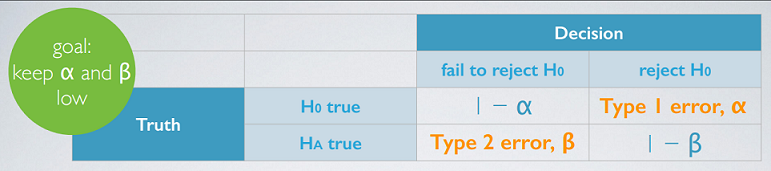

* A type 1 error is rejecting the null hypothesis when the null hypothesis is actually true. So in other words, rejecting the null hypothesis when you should not have. The probability of doing so is alpha, which is the p-value. This is **something we set**, usually we set it at 0.05.
* A type 2 error is failing to reject the null hypothesis when the alternative is true. In other words, it's failing to reject the null hypothesis when you shouldn't have. The probability of doing so is beta, this is **not something we get to set** ahead of time, and its calculation is directly related to the statistical power. 
* **Power** of a test is the probability of correctly rejecting $H_{0}$ and the probability of doing so is $1-\beta$

Our goal, in general, in hypothesis testing, is to **keep both alpha and beta low at the same time**. But we know that as we push one down, the other is going to shoot up. So we usually want to find a delicate **balance** between these two probabilities. 

If the alternative hypothesis is actually true (there is really an effect), what is the chance that we detect the effect? The answer to this is not obvious, because it concerns the **effect size, true difference between null and alternative**. If the true population average is very close to the null value, it will be very difficult to detect a difference and to reject the null hypothesis. In other words, if the true population average is very different from the null value, it will be much easier to detect a difference. Clearly then, **power depends on our effect size**.

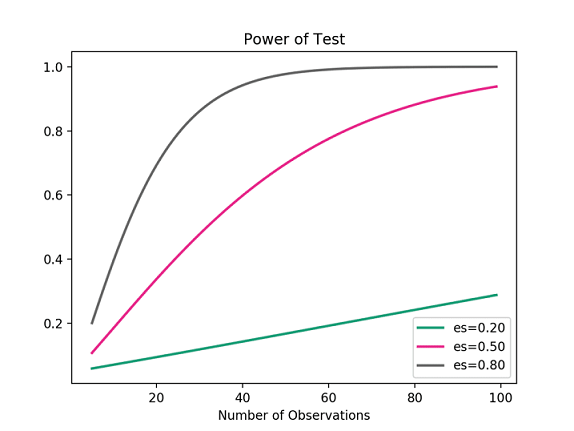

### Main factors
Statistical power depends on three main factors: 
* The magnitude of the effect of interest in the population (**effect size**)
  + Effect size (es) is usually defined as the difference of two group means divided by the pooled standard deviation.
  + When all others are equal, a larger the effect size will lead to more power.
* The **sample size** used to detect the effect
  + More samples will in general increase power. 
* The **statistical significance criterion** used in the test
  + In a single test, this is p-value.
  + For high-dimensional metabolomics data, this is FDR. 
  + When all others are equal, there will be reduced power if we require a very high degree of confidence. 

The first factor (effect size) is **estimated from the data**. The second factor (sample size) is the **interest of the power analysis** (i.e. we want to investigate the statistic power given the current sample size and effect size). The third factor, which needs user to specify, is a significance criterion or **alpha level**. For a single biomarker, this is usually a p-value. For high-dimensional metabolomic data, the common choice is false discovery rate or FDR.

## Power Analysis
Power analysis often refers to calculating the sample size required to detect an effect of a given size with a given degree of confidence.
* Step 1, parameter selection. Select the two groups (in one pairwise comparison) on which to perform power analysis. 
* Step 2, analyze the diagnostic plots which display the distribution of the test statistics and p-values. 
* Step 3, power analysis. **The ultimate aim of power analysis is to determine the minimum sample size used to detect an effect size of interest**. 

Codes used in this demo is modified from `MetaboAnalystR` and implemented using `SSPA`. `SSPA` is removed and not available for `Bioconductor` 3.14. This package is available for version 3.12 of `Bioconductor`. 

In [20]:
suppressWarnings(library("tidyverse"))

options(warn=-1)

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

if (!requireNamespace("SSPA", quietly = TRUE))
    BiocManager::install("SSPA")
#browseVignettes("SSPA") # read more about this package and how it handle power analysis

Set working directory to where the data is. 

In [2]:
setwd("./powerAnalysis/")

Read in demo data. 

In [3]:
fh = read.csv(file = "human_cachexia.csv", header=TRUE) %>%
        as.data.frame()%>%
        column_to_rownames(., var = "Patient.ID")

Check missing values. 

In [4]:
d1 = fh[,-1]
sum(d1==0) ## Total missing values

[1] 0

Check data distribution. 

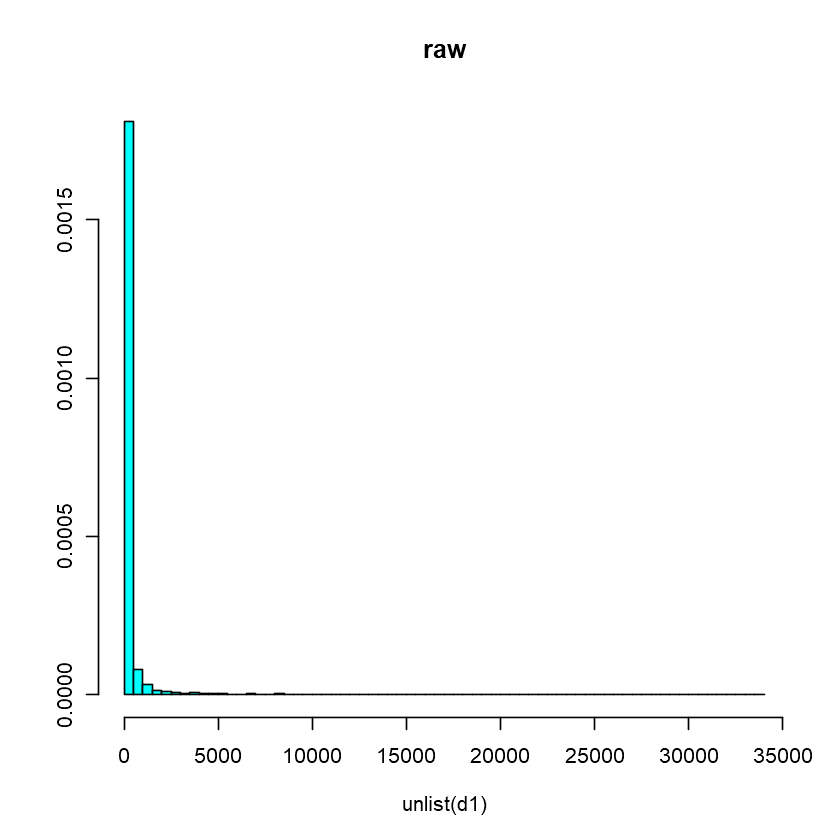

In [5]:
MASS::truehist(unlist(d1), main = "raw", nbins = 50) # not normal, typocal for high-dimension metabolomics data

Log2 transformation. 

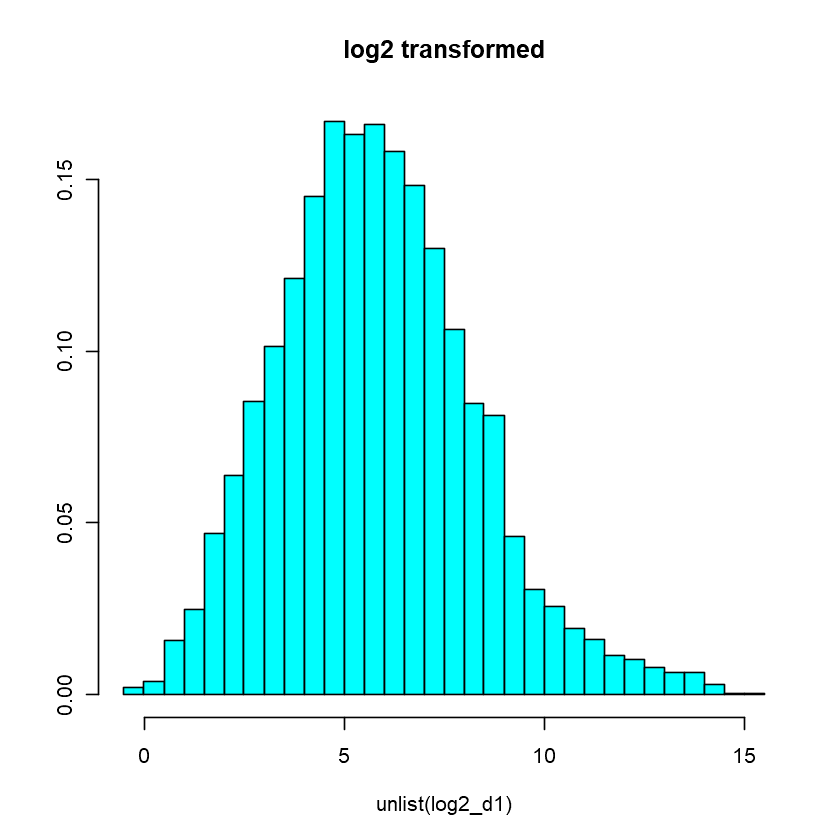

In [6]:
log2_d1 <- log2(type.convert(d1))
MASS::truehist(unlist(log2_d1), main = "log2 transformed", nbins = 50) # near normal

QQ plot is another way to check distribution. 

Creatinine27  Creatinine3 
        1490         1466

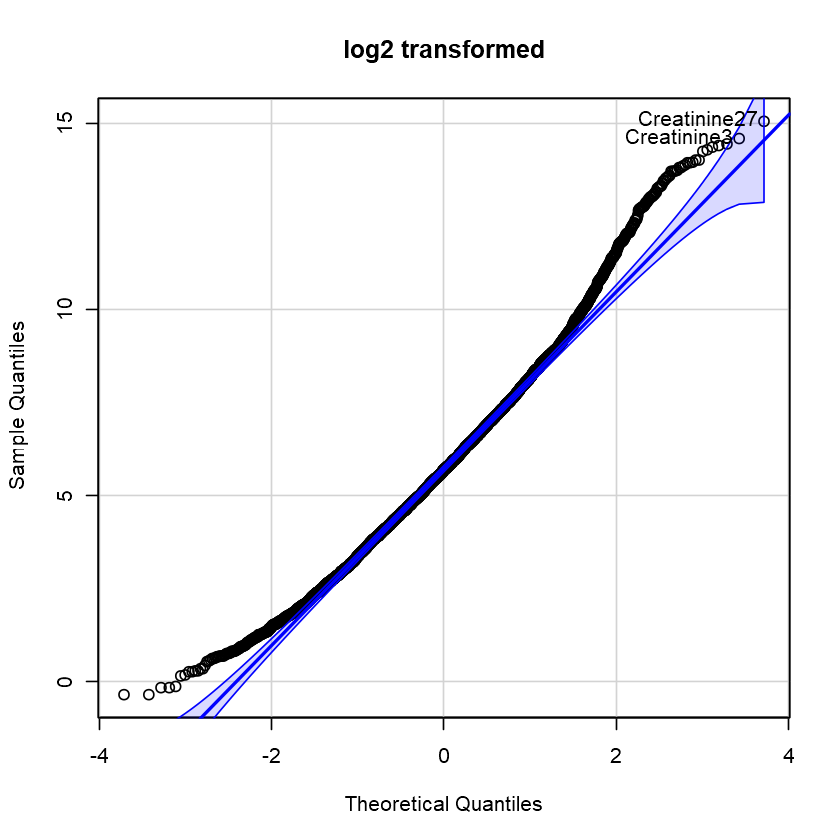

In [7]:
car::qqPlot(unlist(log2_d1), main = "log2 transformed",xlab = "Theoretical Quantiles", ylab = "Sample Quantiles")

There are normalization and scaling methods that can help you make your data looks more similar to Gaussian distribution, but I will stop here and proceed with power analysis. 

Before proceeding to the power analysis, the two groups (in one pairwise comparison) on which to perform power analysis must be selected. There is just pair (two groups) of comparison in our data. In the case there are more than two groups, extend `comparison_list` to include all pairs. 

In [8]:
comparison_list = c("control vs. cachexic") # in the case there are more than two groups, extend this list.
class = as.factor(fh$Muscle.loss)
table(class)

class
cachexic  control 
      47       30 

This data have 30 control samples and 47 cachexic samples. 

Next step is to make diagnostic plots which display a visual overview of the test-statistics and p-values, providing context for whether or not the normalization was sufficient. The shape of the test-statistic should follow a near-normal distribution, and the majority of p-values should be close to zero.
* The test statistics (t-statistics) are expected to follow a near-normal distribution.
* Majority of features should be significantly different between the two selected conditions. You should see some p values (hopefully majority) close to zero (distribution of p-value should be right skewed).

In [9]:
pdD = vector(mode = "list", length = length(comparison_list)) # empty list of pilotData

# construct diagnostic plots for all pairs of comparisons. 
for (i in 1:length(comparison_list)) {
  grp.nms <- strsplit(comparison_list, " vs. ")[[i]]
  inx1 = which(class==grp.nms[1]); inx2 = which(class==grp.nms[2]);
  n1 <- length(inx1); n2 <- length(inx2);

  stats <- apply(log2_d1, 2, function(x) {
    tmp <- try(t.test(x[inx1], x[inx2], paired = FALSE, var.equal = T));
    if(class(tmp) == "try-error") {
      return(NA);
    }else{
      return(tmp$statistic);
    }
  })
  stats <- stats[!is.na(stats)];

  # perform power analysis using SSPA package
  pdD[[i]] <- SSPA::pilotData(statistics = stats,
                         samplesize = sqrt(n1+n2),
                         distribution="t",
                         df=n1+n2-2);
}

Show diagnostic plots. 

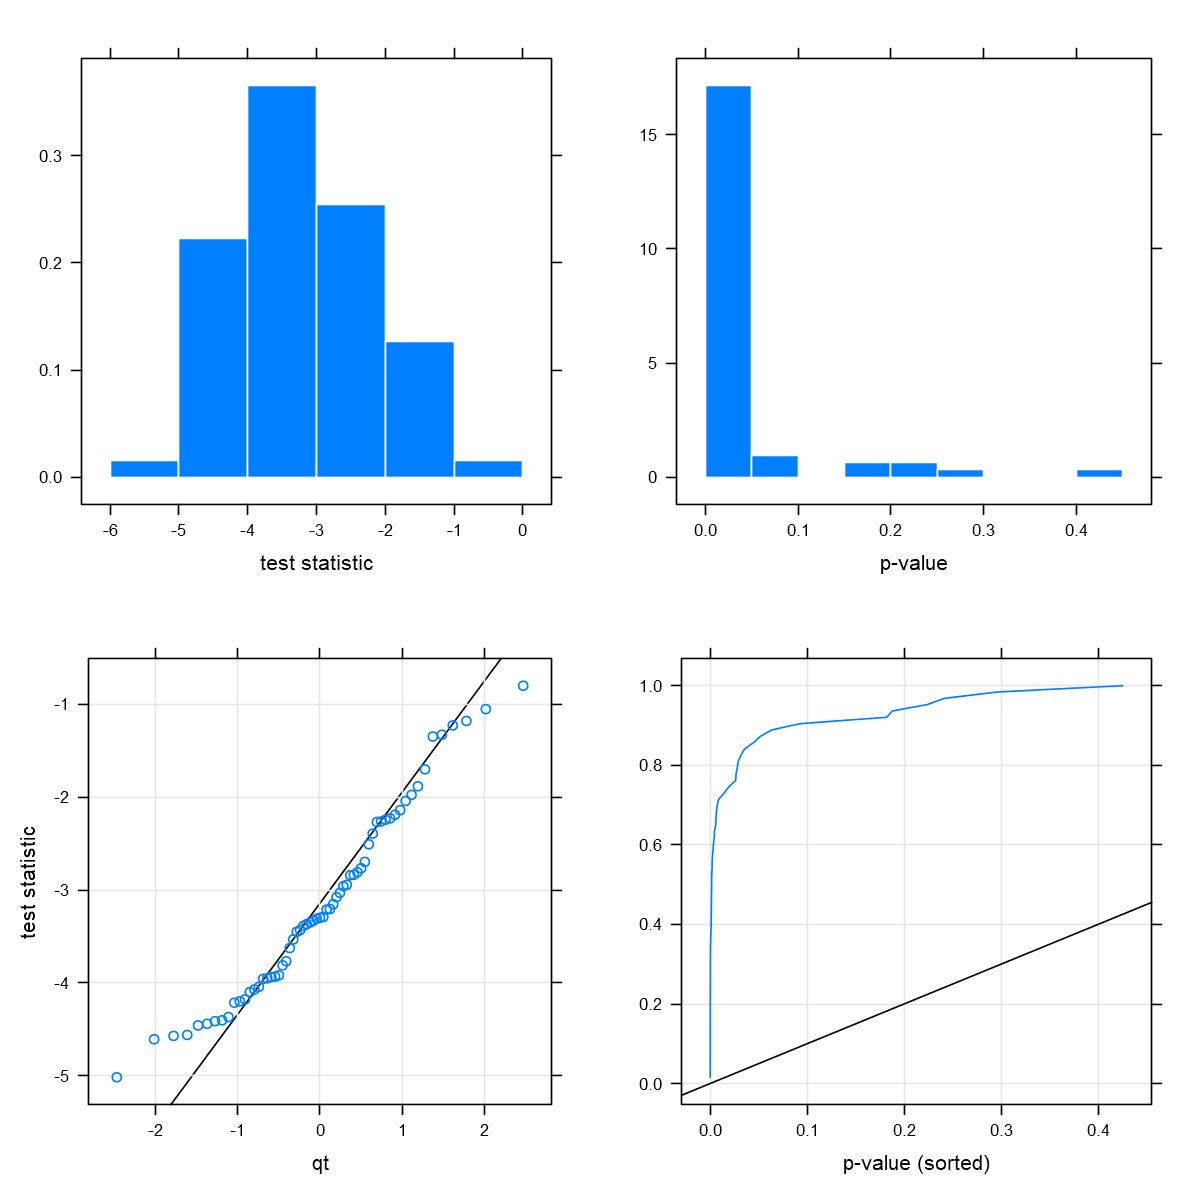

In [10]:
options(repr.plot.width=10, repr.plot.height=10)
SSPA::plot(pdD[[1]]);

The distribution of test statistics is nearly normal (could be better if normalization or scaling methods are applied after log2 transformation, especially looking at the qq plot). For majority of the features, p-values are small, and p-value distribution plot is an ideal rightly skewed shape. 

Next, estimate effect size using our data. 

In [11]:
ssD = vector(mode = "list", length = length(comparison_list)) # empty list to store effectSize

for (i in 1:length(comparison_list)) {
  res <- round(length(pdD[[i]]@statistics)/2);
  ssD[[i]] <- SSPA::sampleSize(pdD[[i]], method="congrad", control=list(from=-6, to=6, resolution=res)); # class SampleSize
}

Show effect size plot. (This plot does not have much use, just for illustration purpose.)

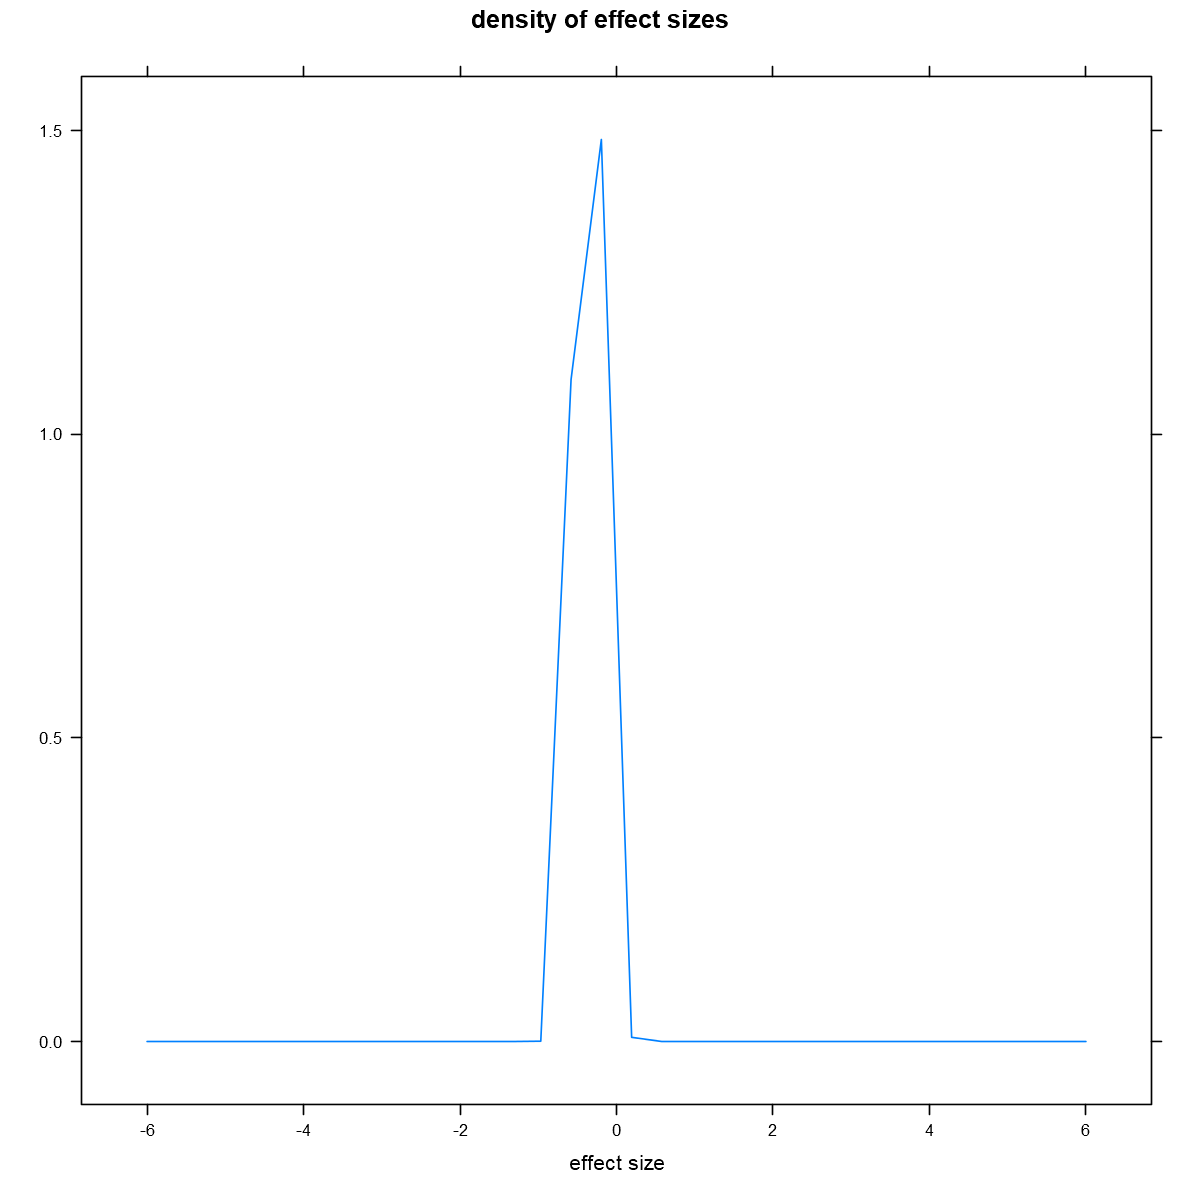

In [12]:
SSPA::plot(ssD[[1]])

Next, set the significance level; In this case, FDR is set at 0.05. 

In [13]:
fdr.lvl = 0.1; # set fdr

Construct a ladder of sample size. In other words, given the data we have (given the effect size we calculated), what are the predicted powers if we have a sample size of 3, 6, 10, 16, 24, etc. 

In [14]:
smplSize = 100; # set predicted power sample size

GetSampleSizeLadder <- function(maxNum){
  Jpred <- c(3, 6, 10, 16, 24, 40, 60, 100, 150, seq(200, 1000, 100));
  inx <- which(Jpred == min(Jpred[Jpred>=maxNum]))
  return(Jpred[1:inx]);
}
Jpred <- GetSampleSizeLadder(smplSize);

Calculate the predicted powers if we have a sample size of 3, 6, 10, 16, 24, etc. 

In [15]:
pwrD = vector(mode = "list", length = length(comparison_list)) # empty list to store predicted Power

for (i in 1:length(comparison_list)) {
  pi0 <- ssD[[i]]@pi0;

  if(fdr.lvl >= pi0){
    fdr.lvl <- signif(pi0-pi0/10, 3);
  }
  pwrD[[i]] <- SSPA::predictpower(ssD[[i]], samplesizes= sqrt(Jpred/2), alpha=fdr.lvl)
}

Create predicted power plot and table. 

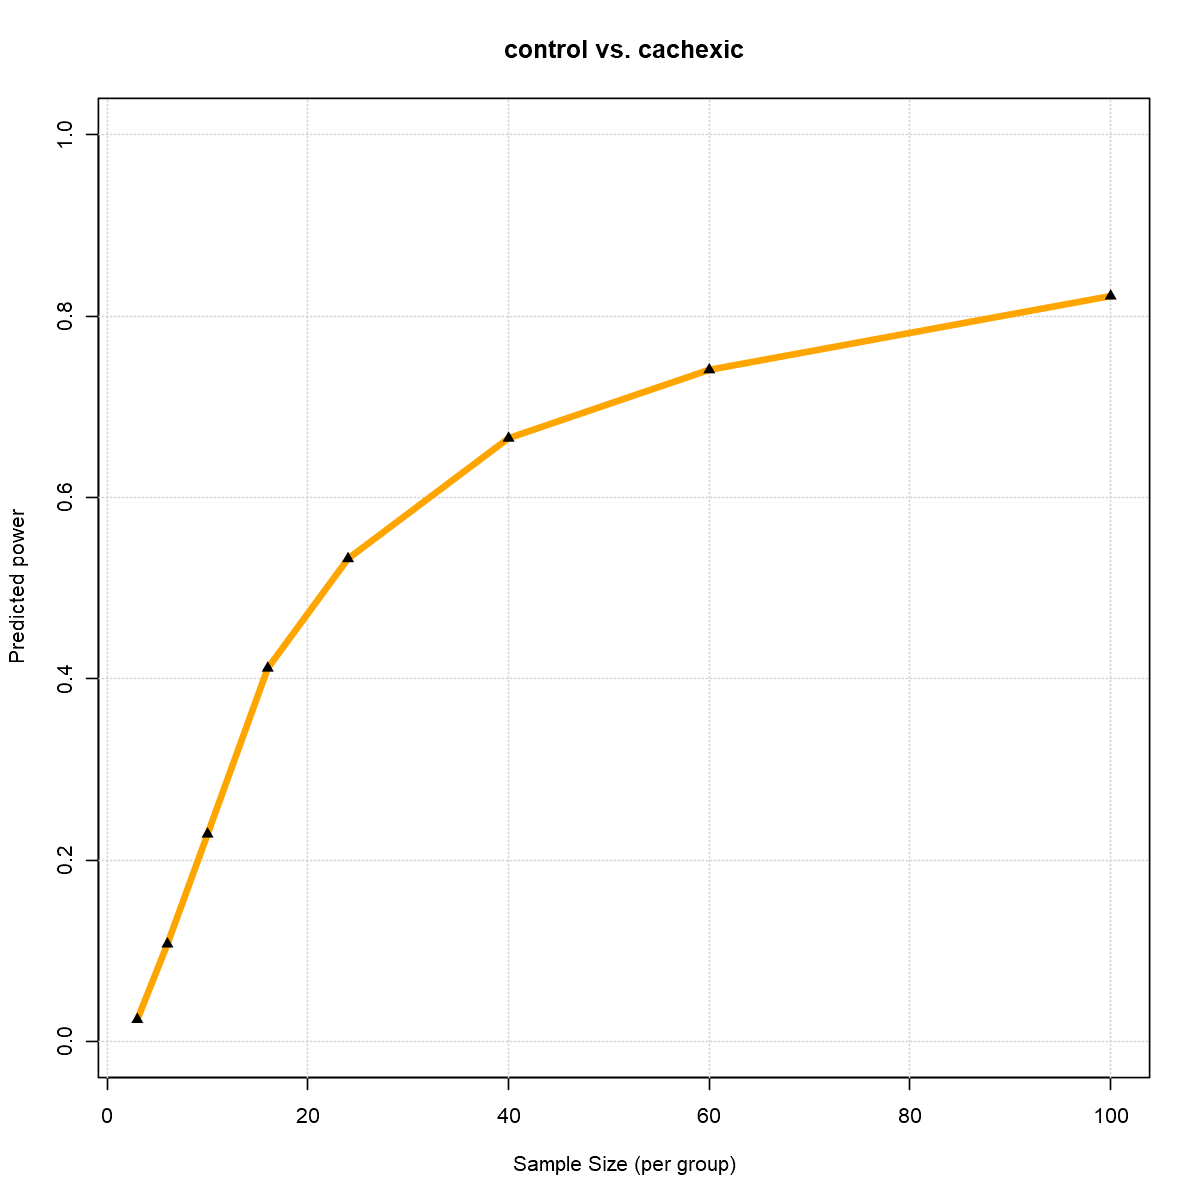

In [16]:
pwrTable = vector(mode = "list", length = length(comparison_list)) # empty list to store result table

for (i in 1:length(comparison_list)) {
  plot(Jpred, pwrD[[i]], type="n", ylim=c(0,1), ylab="Predicted power", xlab="Sample Size (per group)", main= comparison_list[i]);
  grid(col = "lightgray", lty = "dotted", lwd = 1);
  lines(Jpred, pwrD[[i]], lwd=4, col="orange");
  points(Jpred, pwrD[[i]], pch=17);
  pwrTable[[i]] = data.frame(sampleSize = Jpred, predictedPower = pwrD[[i]])
}

In [17]:
pwrTable[[1]]

sampleSize,predictedPower
<dbl>,<dbl>
3,0.02405139
6,0.10730662
10,0.22854185
16,0.41155454
24,0.53228649
40,0.66518181
60,0.74057395
100,0.82196662


Conclusion: with sample size of 47 and 30 (as we showed earlier), the predicted power is 60%~70%, which is an acceptable statistical power. 

One thing to notice is that this experiment is an unbalanced experimental design, which means sample sizes of two groups are not the same. However, when performing statistical tests, **balanced experimental design is usually preferred, as it usually has larger statistical power** ([more on this and detailed math](https://stats.stackexchange.com/questions/44542/experiment-design-can-unbalanced-dataset-be-better-than-balanced)). 

In [18]:
save.image(file = "../demo.rda")